<a href="https://colab.research.google.com/github/northpr/tensorflow-resources/blob/main/natural_language_processing/skimlit_pubmed_w_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skimlit with pretrained model (bert and glove)

Source: [github](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/solutions/%F0%9F%9B%A0_09_Milestone_Project_2_SkimLit_%F0%9F%93%84%F0%9F%94%A5_Exercise_Solutions.ipynb)

# Download data and preprocess

In [1]:
!wget https://raw.githubusercontent.com/northpr/helper_function/master/tensorflow/helper_tensorflow.py

--2022-10-09 20:28:44--  https://raw.githubusercontent.com/northpr/helper_function/master/tensorflow/helper_tensorflow.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7159 (7.0K) [text/plain]
Saving to: ‘helper_tensorflow.py’

helper_tensorflow.p 100%[===================>]   6.99K  --.-KB/s    in 0s      

2022-10-09 20:28:44 (78.1 MB/s) - ‘helper_tensorflow.py’ saved [7159/7159]



In [2]:
import tensorflow as tf
from tensorflow.keras import layers

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [4]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

    # Creating a preprocessing function that returns a dictionary
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [5]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 378 ms, sys: 99.4 ms, total: 478 ms
Wall time: 491 ms


(180040, 30212, 30135)

In [6]:
# Loading our data into a dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [7]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## OneHotEncoder

In [8]:

# One hot encoding the labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## LabelEncoder

In [9]:
# Extract labels and encoder them into integers 
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder() 

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [10]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Using Glove embeddings

In [11]:
# Loading the pre-trained embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-10-09 20:29:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-09 20:29:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-09 20:29:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [12]:
# Getting the path of the glove embedding (using 100D)
import numpy as np 
glove_path = 'glove.6B.100d.txt'

embedding_index = {}

# Making dict of vector representtion of the words (s --> [8, 48......])
with open(glove_path) as f:
  for line in f:
    
    # Getting the words and coef in a variable 
    word , coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs , 'f' , sep = ' ')
    
    # Adding the coefs to our embedding dict 
    embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [13]:
# Make function to split sentence into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-lelve data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

In [14]:
# Creating a text vectorization layer (68k vocab size from the paper itself)
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=68000,
                                    output_sequence_length=56)

# Adapt our text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [15]:
# Getting the vocabulary of the vectorizer
text_vocab = text_vectorizer.get_vocabulary()
len(text_vocab), text_vocab[0:20]

(64841,
 ['',
  '[UNK]',
  'the',
  'and',
  'of',
  'in',
  'to',
  'with',
  'a',
  'were',
  'was',
  'for',
  'patients',
  'group',
  'p',
  'at',
  'or',
  'study',
  'on',
  'treatment'])

### For glove embedding

In [16]:
# Getting the dict mapping word --> index 
word_index_text = dict(zip(text_vocab , range(len(text_vocab))))
word_index_text

{'': 0,
 '[UNK]': 1,
 'the': 2,
 'and': 3,
 'of': 4,
 'in': 5,
 'to': 6,
 'with': 7,
 'a': 8,
 'were': 9,
 'was': 10,
 'for': 11,
 'patients': 12,
 'group': 13,
 'p': 14,
 'at': 15,
 'or': 16,
 'study': 17,
 'on': 18,
 'treatment': 19,
 'is': 20,
 'after': 21,
 'by': 22,
 'this': 23,
 'groups': 24,
 'as': 25,
 'an': 26,
 'from': 27,
 'that': 28,
 'randomized': 29,
 'between': 30,
 'not': 31,
 'trial': 32,
 'no': 33,
 'compared': 34,
 'control': 35,
 'be': 36,
 'significant': 37,
 'intervention': 38,
 'significantly': 39,
 'n': 40,
 'months': 41,
 'than': 42,
 'we': 43,
 'vs': 44,
 'rsb': 45,
 'lsb': 46,
 'clinical': 47,
 'placebo': 48,
 'baseline': 49,
 'ci': 50,
 'two': 51,
 'during': 52,
 'weeks': 53,
 'both': 54,
 'had': 55,
 'primary': 56,
 'mean': 57,
 'are': 58,
 'using': 59,
 'participants': 60,
 'there': 61,
 'all': 62,
 'time': 63,
 'years': 64,
 'pain': 65,
 'therapy': 66,
 'who': 67,
 'mg': 68,
 'more': 69,
 'effect': 70,
 'effects': 71,
 'but': 72,
 'risk': 73,
 'difference

In [17]:
# Creating a function that will give us. a embedding matrix
def get_glove_embedding_matrix(num_tokens, embedding_dim, word_index):

  # Defining the hits and misses here
  hits, misses = 0,0

  # Prepare the embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  return embedding_matrix, hits, misses

In [18]:
num_tokens_text = len(text_vocab)+2 # All number of the words
embedding_dim = 100

sentence_embedding_matrix , hits_ , misses_ = get_glove_embedding_matrix(num_tokens_text , embedding_dim, word_index_text)

print(f'Hits: {hits_} and Misses: {misses_} for the sentence embedding matrix')


Hits: 29730 and Misses: 35111 for the sentence embedding matrix


In [19]:
# Adding the embedding matrix to our Embedding layer (Sentence and characters)
from tensorflow.keras.layers import Embedding

sen_embedding_layer = Embedding(num_tokens_text , 
                            embedding_dim , 
                            embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , 
                            trainable = False,
                            name="glove_embedding")

In [37]:
# Checking the sentence before and after all the vectorization and embedding
import random

random_sentence = random.choice(train_sentences)

print(f"Example of train sentence:\n{random_sentence}")

print("=======\n")
print(f"Text vectorization:\n{text_vectorizer(random_sentence)}")
print(f"Text vectorization shape: {text_vectorizer(random_sentence).shape}")

print("=======\n")
print(f"Embedded Text:\n{sen_embedding_layer(text_vectorizer(random_sentence))}\n")
print(f"Embedded text shape: {sen_embedding_layer(text_vectorizer(random_sentence)).shape}")


Example of train sentence:
two important implications of these findings are that wisdom entails an appreciation of life and its experiences , especially the growth opportunities that may result from negative events , and that there may be substantial differences between male and female pathways to wisdom .

Text vectorization:
[   51   430  1946     4   111   310    58    28 12856 17238    26 14242
     4   195     3   308  2124  1006     2   621  4064    28    91   692
    27   469   124     3    28    61    91    36  1492   102    30   564
     3   619  2819     6 12856     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
Text vectorization shape: (56,)

Embedded Text:
[[-2.0154e-01  3.2739e-01  4.7580e-04 ...  2.3054e-02  5.4016e-01
  -8.0331e-02]
 [-5.5556e-01  2.7332e-01  9.8191e-02 ... -1.0519e+00  3.4562e-01
   1.1396e+00]
 [ 2.3927e-01  3.3944e-01  6.0325e-01 ... -2.3648e-01  3.9020e-01
   6.3559e-01]
 ...
 [ 0.0000e+00  0.0000e+00  0.0000

In [21]:
# Creating the datasets for our both sentences and chars  

train_sen_vectors = text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy()
val_sen_vectors = text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

# Training and validation dataset 
train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors , train_labels_encoded)) # For model 1
val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors , val_labels_encoded))


# Applying the batch size and prefetching (performance optimization )
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


train_ds,  val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [22]:
# Check the shape of the input
train_sen_vectors.shape

(180040, 56)

In [23]:
train_sen_vectors[0].shape

(56,)

### Model 0: Glove embedding test with sentences

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
len(train_sentences), len(train_labels_one_hot)

(180040, 180040)

In [26]:
tf.random.set_seed(123)

# Sample
inputs = layers.Input(shape= (1,), dtype="string")
text_vector = text_vectorizer(inputs)
glove_emb = sen_embedding_layer(text_vector)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(glove_emb)
x = layers.AveragePooling1D(5, padding="same")(x)
x = layers.Conv1D(64, 5, activation="relu", padding="same")(x)
x = layers.AveragePooling1D(5, padding="same")(x)
x = layers.Conv1D(32, 5, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_0 = tf.keras.Model(inputs, outputs, name="conv1d_global_average_pooling")
model_0.summary()

Model: "conv1d_global_average_pooling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 56)               0         
 torization)                                                     
                                                                 
 glove_embedding (Embedding)  (None, 56, 100)          6484300   
                                                                 
 conv1d (Conv1D)             (None, 56, 128)           64128     
                                                                 
 average_pooling1d (AverageP  (None, 12, 128)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 1

In [27]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

model_0.fit(train_dataset,
            epochs=5,
            validation_data=valid_dataset)

Epoch 1/5
5627/5627 [==============================] - 39s 5ms/step - loss: 0.6639 - accuracy: 0.7522 - val_loss: 0.5265 - val_accuracy: 0.8051
Epoch 2/5
5627/5627 [==============================] - 29s 5ms/step - loss: 0.5244 - accuracy: 0.8106 - val_loss: 0.5059 - val_accuracy: 0.8138
Epoch 3/5
5627/5627 [==============================] - 29s 5ms/step - loss: 0.4768 - accuracy: 0.8280 - val_loss: 0.5043 - val_accuracy: 0.8149
Epoch 4/5
5627/5627 [==============================] - 30s 5ms/step - loss: 0.4404 - accuracy: 0.8413 - val_loss: 0.5209 - val_accuracy: 0.8140
Epoch 5/5
5627/5627 [==============================] - 29s 5ms/step - loss: 0.4128 - accuracy: 0.8501 - val_loss: 0.5727 - val_accuracy: 0.8054


In [28]:
evaluate_0 = model_0.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5727 - accuracy: 0.8054


### Model 1: Glove embedding with GlobalAveragePooling

In [43]:
tf.random.set_seed(123)

# Sample
inputs = layers.Input(shape= (None,), dtype="int64") # Data is already `int64` because we already vectorize it.
glove_emb = sen_embedding_layer(inputs)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(glove_emb)
x = layers.AveragePooling1D(5, padding="same")(x)
x = layers.Conv1D(64, 5, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="conv1d_global_average_pooling")
model_1.summary()

Model: "conv1d_global_average_pooling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 glove_embedding (Embedding)  multiple                 6484300   
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         64128     
                                                                 
 average_pooling1d_4 (Averag  (None, None, 128)        0         
 ePooling1D)                                                     
                                                                 
 conv1d_10 (Conv1D)          (None, None, 64)          41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)            

In [44]:
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

model_1.fit(train_ds,
            epochs=5,   
            validation_data = val_ds)

Epoch 1/5
5627/5627 [==============================] - 27s 5ms/step - loss: 0.6674 - accuracy: 0.7519 - val_loss: 0.5334 - val_accuracy: 0.8027
Epoch 2/5
5627/5627 [==============================] - 23s 4ms/step - loss: 0.5270 - accuracy: 0.8080 - val_loss: 0.5103 - val_accuracy: 0.8120
Epoch 3/5
5627/5627 [==============================] - 25s 4ms/step - loss: 0.4832 - accuracy: 0.8244 - val_loss: 0.4937 - val_accuracy: 0.8202
Epoch 4/5
5627/5627 [==============================] - 23s 4ms/step - loss: 0.4501 - accuracy: 0.8364 - val_loss: 0.5056 - val_accuracy: 0.8171
Epoch 5/5
5627/5627 [==============================] - 25s 4ms/step - loss: 0.4226 - accuracy: 0.8453 - val_loss: 0.5098 - val_accuracy: 0.8170


In [45]:
evaluate_1 = model_1.evaluate(val_ds)

945/945 [==============================] - 2s 2ms/step - loss: 0.5098 - accuracy: 0.8170


### Model 2: Glove embedding with MaxPooling

In [48]:
tf.random.set_seed(123)

# Sample
inputs = layers.Input(shape= (None,), dtype="int64") # Data is already `int64` because we already vectorize it.
glove_emb = sen_embedding_layer(inputs)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(glove_emb)
x = layers.MaxPooling1D(5, padding="same")(x)
x = layers.Conv1D(32, 5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="conv1d_global_average_pooling")
model_2.summary()

Model: "conv1d_global_average_pooling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 glove_embedding (Embedding)  multiple                 6484300   
                                                                 
 conv1d_14 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, None, 32)          20512     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                    

In [49]:
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

model_2.fit(train_ds,
            epochs=5,   
            validation_data = val_ds)

Epoch 1/5
5627/5627 [==============================] - 24s 4ms/step - loss: 0.7469 - accuracy: 0.7232 - val_loss: 0.6091 - val_accuracy: 0.7770
Epoch 2/5
5627/5627 [==============================] - 23s 4ms/step - loss: 0.5976 - accuracy: 0.7890 - val_loss: 0.5399 - val_accuracy: 0.8023
Epoch 3/5
5627/5627 [==============================] - 23s 4ms/step - loss: 0.5473 - accuracy: 0.8063 - val_loss: 0.5628 - val_accuracy: 0.8017
Epoch 4/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.5174 - accuracy: 0.8167 - val_loss: 0.5805 - val_accuracy: 0.8007
Epoch 5/5
5627/5627 [==============================] - 30s 5ms/step - loss: 0.4917 - accuracy: 0.8246 - val_loss: 0.5631 - val_accuracy: 0.8035


In [50]:
evaluate_2 = model_2.evaluate(val_ds)

945/945 [==============================] - 2s 2ms/step - loss: 0.5631 - accuracy: 0.8035


## Create a character-level vectorization and embedding

In [35]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
random_sentence = random.choice(train_sentences)
split_chars(random_sentence)

'a f t e r   t r e a t m e n t   ,   t h e   t i m e s   o f   u r i n e   l e a k a g e   ,   m a x i m u m   u r i n e   o u t p u t   ,   b l a d d e r   c a p a c i t y   a n d   r e s i d u a l   u r i n e   w e r e   a l l   i m p r o v e d   i n   t w o   g r o u p s   (   a l l   p   <   @   )   .'

In [38]:
# Spit all the sentence in train sentences to char-level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [51]:
# Finding most of the character length in a sentence
char_lens = [len(sentence) for sentence in train_sentences]
np.mean(char_lens)

149.3662574983337

In [52]:
# Find 95% of the character length
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [53]:
# Get all keyboard characters for char-level embedding (for text-vectorization)
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Char-level text vectorization

In [62]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS+2,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to the data
char_vectorizer.adapt(train_chars)

In [63]:
# Try vectorization on the random set of characters
random_train_chars = random.choice(train_chars)

random_train_chars, char_vectorizer(random_train_chars), char_vectorizer(random_train_chars).shape

('e v e n t - f r e e   s u r v i v a l   a t   @   (   @   )   m o n t h s   w a s   o b s e r v e d   i n   @   %   (   @   %   )   o f   p a t i e n t s   r a n d o m i z e d   t o   a   m i d - s e p t a l   a n d   i n   @   %   (   @   %   )   o f   p a t i e n t s   r a n d o m i z e d   t o   a n   a p i c a l   l e a d   p o s i t i o n   ,   p   =   @   (   p   =   @   )   .',
 <tf.Tensor: shape=(290,), dtype=int64, numpy=
 array([ 2, 21,  2,  6,  3, 17,  8,  2,  2,  9, 16,  8, 21,  4, 21,  5, 12,
         5,  3, 15,  7,  6,  3, 13,  9, 20,  5,  9,  7, 22,  9,  2,  8, 21,
         2, 10,  4,  6,  7, 17, 14,  5,  3,  4,  2,  6,  3,  9,  8,  5,  6,
        10,  7, 15,  4, 25,  2, 10,  3,  7,  5, 15,  4, 10,  9,  2, 14,  3,
         5, 12,  5,  6, 10,  4,  6,  7, 17, 14,  5,  3,  4,  2,  6,  3,  9,
         8,  5,  6, 10,  7, 15,  4, 25,  2, 10,  3,  7,  5,  6,  5, 14,  4,
        11,  5, 12, 12,  2,  5, 10, 14,  7,  9,  4,  3,  4,  7,  6, 14, 14,
         0,  0,  0,  0,  0,  0,

In [64]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Char-level text embedding

In [77]:
char_embedder = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                 output_dim=40,
                 name="char_embed")

In [78]:
# Test out character embedding layer
random_chars = random.choice(train_chars)
print(f"Random sentence to character level:\n {random_chars}")
print("===========")
print(f"Sentence after text vectorization:\n {char_vectorizer(random_chars)}")
print("===========")
print(f"Sentence after text embedding:\n{char_embedding(char_vectorizer(random_chars))}")
print("===========\n")

print(f"Shape of text vectorization: {char_vectorizer(random_chars).shape}")
print(f"Shape of text embedding: {char_embedding(char_vectorizer(random_chars)).shape}")

Random sentence to character level:
 b o t h   t h e   g r o u p s   e x h i b i t e d   s i g n i f i c a n t l y - i m p r o v e d   a r e a r a t i o - t o t a l   v a l u e   a n d   i n s i g n i f i c a n t l y   d e t e r i o r a t e d   a r e a r a t i o - h o   v a l u e   t h r o u g h o u t   t h e   p o s t o p e r a t i v e   p e r i o d   .
Sentence after text vectorization:
 [22  7  3 13  3 13  2 18  8  7 16 14  9  2 24 13  4 22  4  3  2 10  9  4
 18  6  4 17  4 11  5  6  3 12 19  4 15 14  8  7 21  2 10  5  8  2  5  8
  5  3  4  7  3  7  3  5 12 21  5 12 16  2  5  6 10  4  6  9  4 18  6  4
 17  4 11  5  6  3 12 19 10  2  3  2  8  4  7  8  5  3  2 10  5  8  2  5
  8  5  3  4  7 13  7 21  5 12 16  2  3 13  8  7 16 18 13  7 16  3  3 13
  2 14  7  9  3  7 14  2  8  5  3  4 21  2 14  2  8  4  7 10  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  

## Model 3: Combined AveragePoolingLayer with Chars embedding

In [124]:
tf.random.set_seed(123)

# 1. Setup glove embedding test AveragePooling
glove_inputs = layers.Input(shape= (1,), dtype="string", name="glove_inputs")
text_vector = text_vectorizer(glove_inputs)
glove_emb = sen_embedding_layer(text_vector)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(glove_emb)
x = layers.AveragePooling1D(5, padding="same")(x)
x = layers.Conv1D(64, 5, activation="relu", padding="same")(x)
x = layers.AveragePooling1D(5, padding="same")(x)
x = layers.Conv1D(32, 5, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)
# print(x.shape)
glove_embedding_outputs = layers.Dense(128, activation="relu")(x)
glove_model = tf.keras.Model(inputs=glove_inputs,
                             outputs=glove_embedding_outputs)

# 2. Setup char model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embedder(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embedding)
# print(char_bi_lstm.shape) # To check the shape for debugging
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs
glove_char_concat = layers.Concatenate(name="glove_char_hybrid")([glove_model.output,
                                                                  char_model.output])

# 4. Create outer layers and dropout
combined_dropout = layers.Dropout(0.5)(glove_char_concat)
final_layers = layers.Dense(128, activation="relu")(combined_dropout)
final_layers = layers.Dense(32, activation="relu")(final_layers)
final_layers = layers.Dropout(0.3)(final_layers)
output_layer = layers.Dense(num_classes, activation="softmax")(final_layers)

# 5. Construct model
model_3 = tf.keras.Model(inputs=[glove_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_3_glove_char_embedding")

model_3.summary()

Model: "model_3_glove_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 glove_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 56)          0           ['glove_inputs[0][0]']           
 ization)                                                                                         
                                                                                                  
 glove_embedding (Embedding)    multiple             6484300     ['text_vectorization[14][0]']    
                                                                                                  
 conv1d_47 (Conv1D)             (None, 56, 128)      64128       ['glov

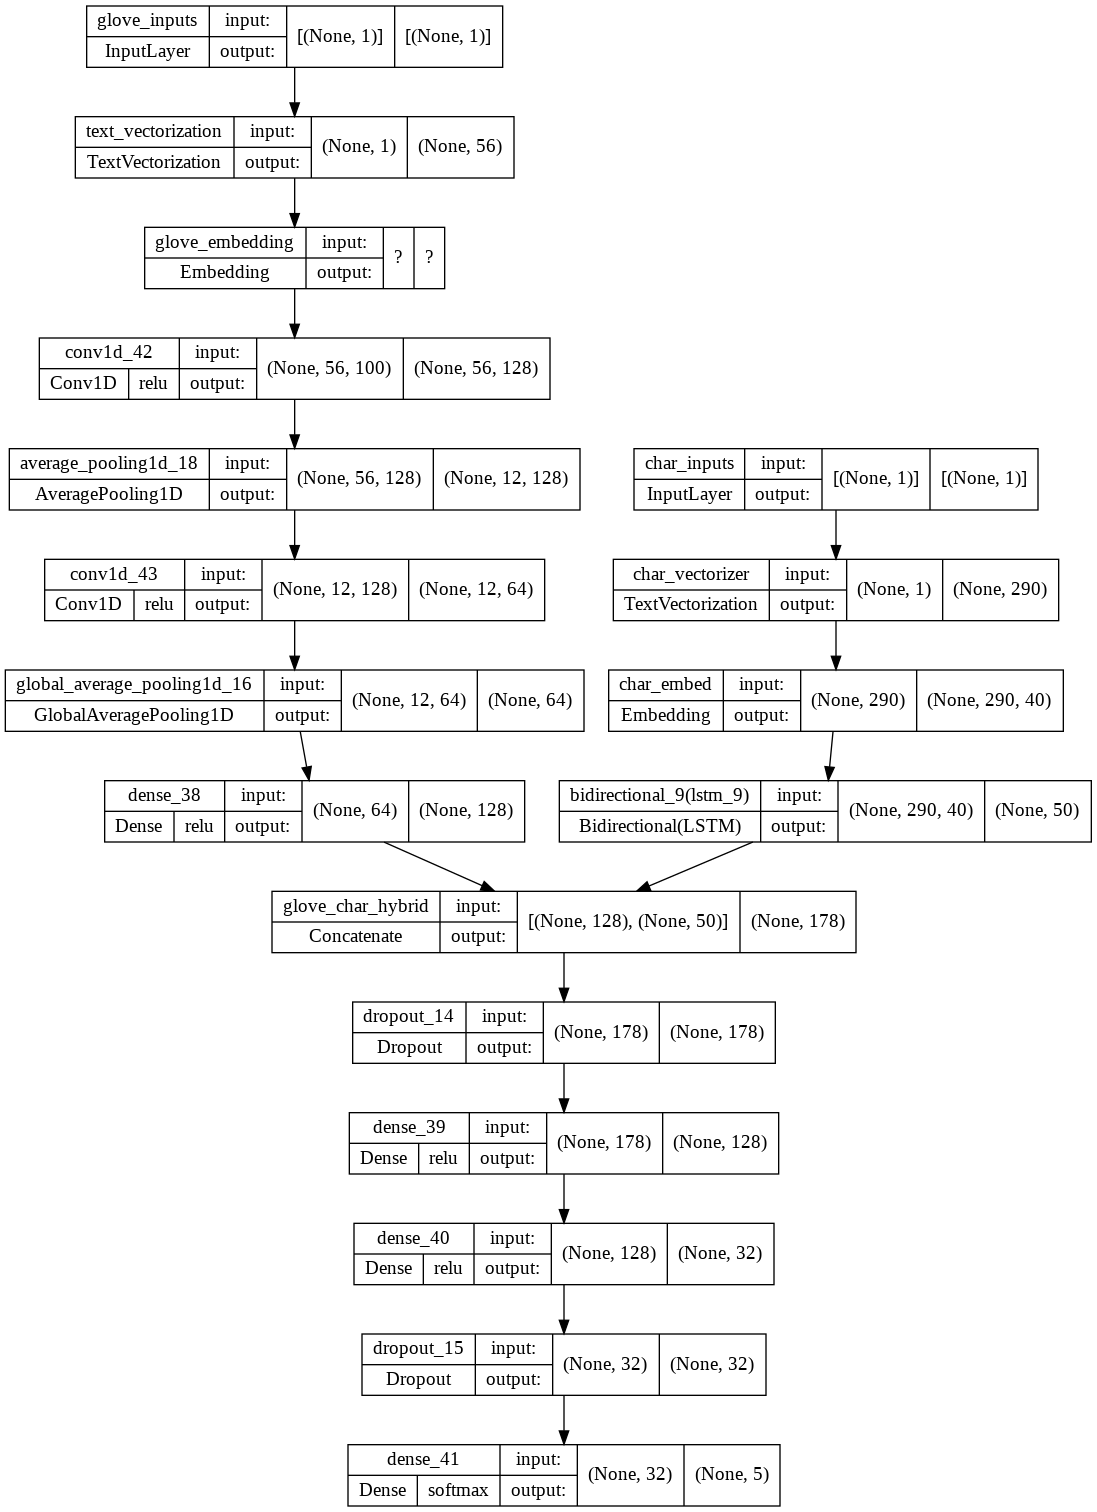

In [110]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, show_shapes=True, show_layer_activations=True)

### Prepare the data for model 3

In [105]:
train_sentences[0], train_chars[0]

('to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .')

In [106]:
# # Combine chars and tokens into a dataset
# train_sen_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
# train_sen_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
# train_sen_char_dataset = tf.data.Dataset.zip((train_sen_char_data, train_sen_char_labels))

# # Prefetch and batch train data
# train_char_token_dataset = train_sen_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# # Repeat same steps to validation data
# val_sen_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
# val_sen_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
# val_sen_char_dataset = tf.data.Dataset.zip((val_sen_char_data, val_sen_char_labels))
# val_char_token_dataset = val_sen_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Compile and fit

In [115]:
# Compile the model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [117]:
model_3.fit(train_char_token_dataset,
            epochs=5,
            validation_data=val_char_token_dataset)

Epoch 1/5
5627/5627 [==============================] - 139s 25ms/step - loss: 0.6722 - accuracy: 0.7549 - val_loss: 0.5429 - val_accuracy: 0.8034
Epoch 2/5
5627/5627 [==============================] - 136s 24ms/step - loss: 0.5557 - accuracy: 0.8027 - val_loss: 0.5194 - val_accuracy: 0.8132
Epoch 3/5
5627/5627 [==============================] - 136s 24ms/step - loss: 0.5095 - accuracy: 0.8196 - val_loss: 0.5410 - val_accuracy: 0.8094
Epoch 4/5
5627/5627 [==============================] - 136s 24ms/step - loss: 0.4795 - accuracy: 0.8308 - val_loss: 0.5320 - val_accuracy: 0.8148
Epoch 5/5
5627/5627 [==============================] - 136s 24ms/step - loss: 0.4526 - accuracy: 0.8399 - val_loss: 0.5317 - val_accuracy: 0.8152


In [120]:
evaluate_3 = model_3.evaluate(val_char_token_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.5317 - accuracy: 0.8152


In [121]:
evaluate_2

[0.5631232857704163, 0.8034555912017822]

In [122]:
evaluate_1

[0.509758710861206, 0.8170263767242432]